In [4]:
%matplotlib inline
import numpy as np
import obspy
import Strain
import glob,os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize']=10,6

In [7]:
# pick a station and read the data
# data are converted from the 4 gages with a specified calibration
stn = 'B004'
# explicitly specify which files to read
# for the gage data
fls = glob.glob(os.path.join('example-data-B004','*B004*RS*.SAC'))
# and the atmospheric data
flsa = glob.glob(os.path.join('example-data-B004','*B004*RDO*.SAC'))
# note that it's also reading quality indicators from directory $STRAINPROC/QUALSAC

st = Strain.readwrite.read(stn,calib='default',fls=fls,flsa=flsa,chqual=True)

/apps/developers/compilers/canopy/1.7.4/1/bit-64/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
Strain/readwrite.py:317: RuntimeWarning: divide by zero encountered in divide
  (tri/1.e+8)/(1.-(tri/1.e+8)))*gp/diam


In [8]:
# the stream st contains traces for each component
# E+N (areal), E-N (different extension), 2EN (engineering shear)
# and RDO (atmospheric pressure)
# data not assigned a quality of "good" in the UNAVCO database are masked
print(st)

4 Trace(s) in Stream:
PB.B004.T0.E+N | 2007-04-01T21:29:59.809835Z - 2017-05-10T23:49:52.085513Z | 600.0 s, 531663 samples (masked)
PB.B004.T0.E-N | 2007-04-01T21:29:59.809835Z - 2017-05-10T23:49:52.085513Z | 600.0 s, 531663 samples (masked)
PB.B004.T0.2EN | 2007-04-01T21:29:59.809835Z - 2017-05-10T23:49:52.085513Z | 600.0 s, 531663 samples (masked)
PB.B004.TS.RDO | 2007-04-01T21:29:59.809835Z - 2017-05-10T23:49:52.085513Z | 600.0 s, 531663 samples (masked)


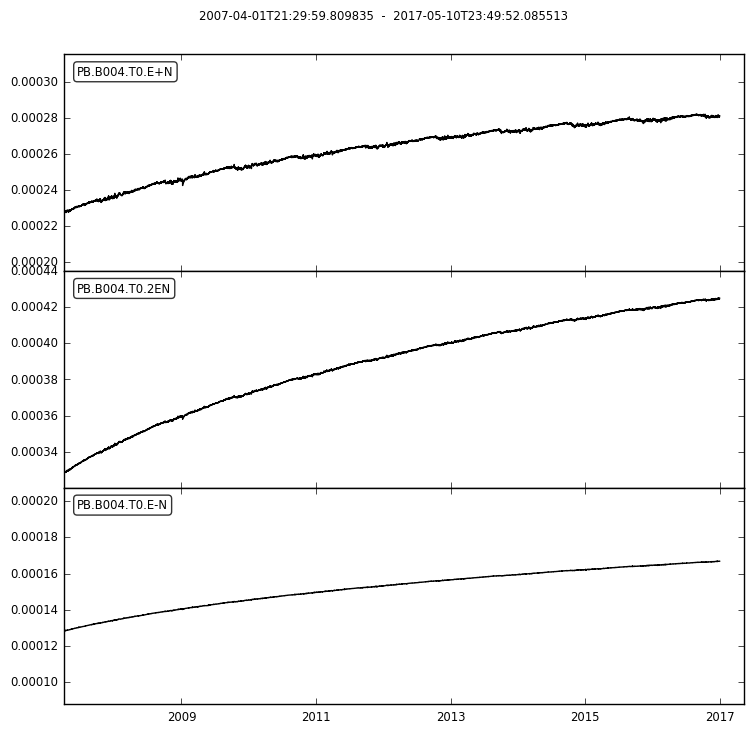

In [9]:
st.select(channel='*E*').plot(method='full')

In [10]:
# first estimate and remove a long-term trend and exponential strain,
# mostly to remove the long-term borehole curing

# to estimate a correction, create a dictionary with the input fit parameters
fpar = {'fitlinear':True,'fitconstant':True,'fitexp':True,
        'flm':np.array([0,float('inf')]),'expdec':300,
        'expdeclim':np.array([30,3000])}

# then compute the output fit parameters
# this might take a few minutes
X,Xb=Strain.fits.fits.fit(st,fpar=fpar)


In [11]:
# the output parameters are a dictionary of the parameters for each component
# so to see the parameters estimated for differential extension
print(X['E-N'])

{'expdec': masked_array(data = [ 1083.46896195],
             mask = False,
       fill_value = 1e+20)
, 'constant': masked_array(data = [ 0.00015937],
             mask = False,
       fill_value = 1e+20)
, 'linear': masked_array(data = [  5.79526766e-09],
             mask = False,
       fill_value = 1e+20)
, 'exp': masked_array(data = [ -1.25824593e-05],
             mask = False,
       fill_value = 1e+20)
, 'exptref': UTCDateTime(2008, 6, 22, 18, 29, 58, 663613)}


In [12]:
# the input parameters are updated as well
print(fpar)

{'fitdaily': 0, 'fitexp': True, 'expdeclast': {'E+N': masked_array(data = [ 1201.67126116],
             mask = False,
       fill_value = 1e+20)
, 'E-N': masked_array(data = [ 1078.15865276],
             mask = False,
       fill_value = 1e+20)
, '2EN': masked_array(data = [ 1084.29003891],
             mask = False,
       fill_value = 1e+20)
}, 'expdeclim': {'E+N': array([[   30.,  3000.]]), 'E-N': array([[   30.,  3000.]]), '2EN': array([[   30.,  3000.]])}, 'fitdelresp': 0, 'tdel': [], 'fitatm': 0, 'fitconstant': True, 'chfit': array(['E+N', 'E-N', '2EN'], 
      dtype='|S3'), 'flm': array([  0.,  inf]), 'exptref': UTCDateTime(2008, 6, 22, 18, 29, 58, 663613), 'starttime': UTCDateTime(2008, 9, 30, 18, 29, 59, 809835), 'fittides': 0, 'expdec': {'E+N': masked_array(data = [ 1207.62964126],
             mask = False,
       fill_value = 1e+20)
, 'E-N': masked_array(data = [ 1083.46896195],
             mask = False,
       fill_value = 1e+20)
, '2EN': masked_array(data = [ 1089.7295

In [13]:
# use the output fit parameters to correct the data
stc,stp=Strain.fits.fits.correct(st,fpar,X)


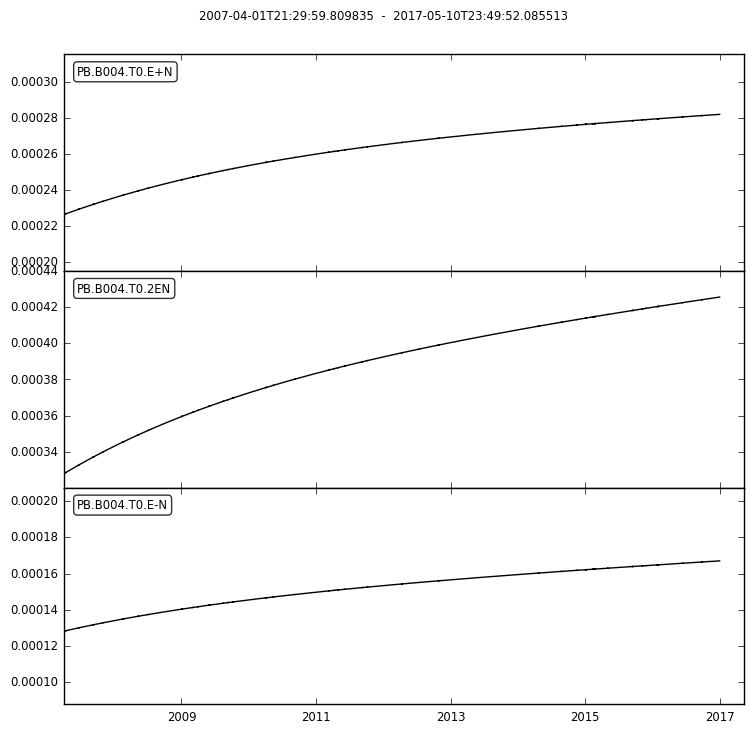

In [14]:
# this outputs the corrections used in stp
stp.plot(method='full')

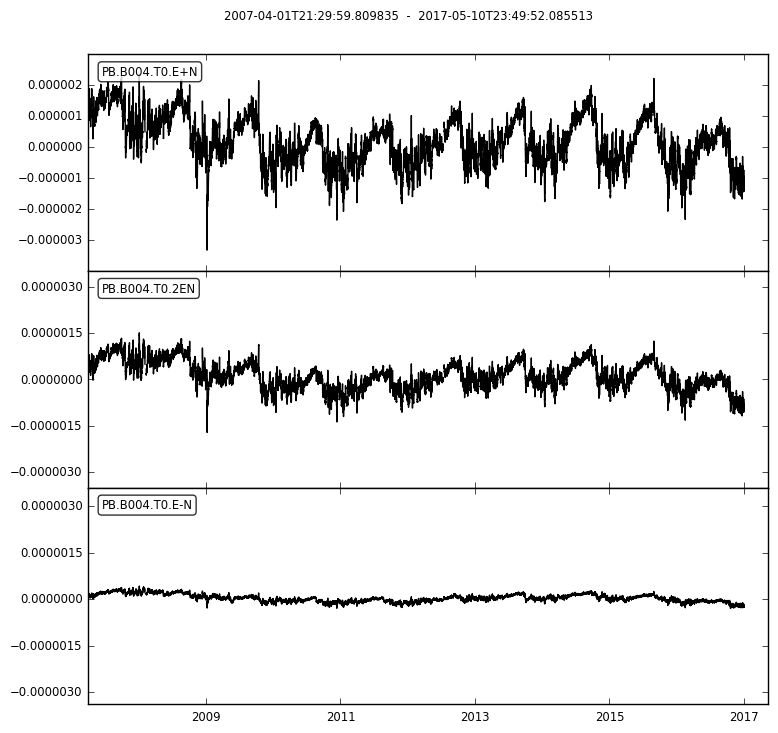

In [15]:
# it also outputs the corrected data,
# which should be flat since the trend has been removed
# leftover are seasonal variations, pressure responses, tides,
# and everything else
stc.select(channel='*E*').plot(method='full')

In [16]:
# note that large variation is left at early times because
# the start time for parameter estimation is after the data start time
print('Data start time: '+str(stc[0].stats.starttime))

print('Fit start time: '+str(fpar['starttime']))


Data start time: 2007-04-01T21:29:59.809835Z
Fit start time: 2008-09-30T18:29:59.809835Z


In [17]:
# now that we have a reasonably flat time series, 
# move on to more interesting corrections

# a new set of fit parameters, to remove tides and atmospheric pressure
fpar2 = {'fittides':True,'fitatm':True}

# specify tidal coefficients that are expected to be visible at roughly one 
# standard deviation level
fpar2['tidespec']='snr'
fpar2['tidepar']=1.

# compute the correction parameters in a limited frequency band (specified in Hz)
# note the actual corrections computed with fits.correct are at all frequencies---it's only
# the parameters that are estimated after filtering
fpar2['flm']=np.array([1./2.,6.])/86400.

# to save time in the example, 
# only compute the corrections using data from a one-year period
# for actual processing this should be changed,
# but it's generally a good idea to exclude the first year or so
fpar2['starttime']=obspy.UTCDateTime(2011,1,1)
fpar2['endtime']=obspy.UTCDateTime(2012,1,1)

print(fpar2)

{'fitatm': True, 'flm': array([  5.78703704e-06,   6.94444444e-05]), 'starttime': UTCDateTime(2011, 1, 1, 0, 0), 'fittides': True, 'tidepar': 1.0, 'endtime': UTCDateTime(2012, 1, 1, 0, 0), 'tidespec': 'snr'}


In [18]:
# compute the parameters---will take a while
X2,Xb2=Strain.fits.fits.fit(stc,fpar=fpar2)

In [22]:
# note that with these parameters,
# the tidal components used were selected based on the expected signal to noie at each station
print(fpar2['tfreq'])

{'E+N': array([ 0.92953571,  1.00273791,  1.89598197,  1.93227361,  2.        ,
        2.00547582]), u'RDO': array([], dtype=float64), 'E-N': array([ 0.89324406,  0.92938861,  0.92953571,  0.99726209,  1.00273791,
        1.002885  ,  1.85969032,  1.86454723,  1.89598197,  1.90083888,
        1.93212652,  1.93227361,  1.96856526,  1.99726222,  2.        ,
        2.00547582,  2.00562291,  2.89841042]), '2EN': array([ 0.92953571,  0.99726209,  1.00273791,  1.89598197,  1.93227361,
        2.        ,  2.00547582])}


In [23]:
# add these corrections
stc2,stp2=Strain.fits.fits.correct(stc,fpar=fpar2,X=X2)

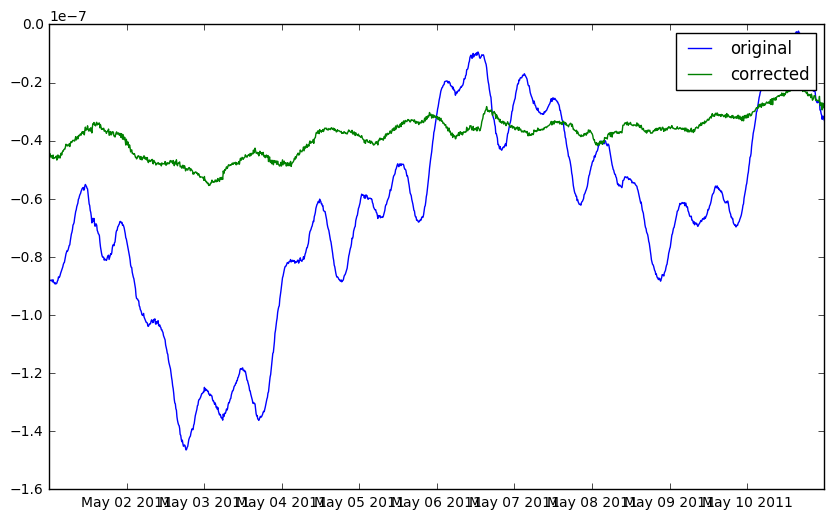

In [25]:
# plot the results in one 10-day time window
tst=obspy.UTCDateTime(2011,5,1)
tnd=tst+10*86400.
from matplotlib.dates import date2num
tstp,tndp=date2num(tst),date2num(tnd)

# compare some of the original data
tim,data=Strain.toplot.timdata(stc.select(channel='E-N')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii],linestyle='-',marker=None,label='original',
                 color='b')

# compare some of the corrected data
tim,data=Strain.toplot.timdata(stc2.select(channel='E-N')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii],linestyle='-',marker=None,label='corrected',
                 color='g')

plt.legend()


In [26]:
# from these corrections, we have amplitudes of the atmospheric response 
# on each component
print('barometric response coefficients in strain per Pa')
for ch in X2.keys():
    print(ch+': '+str(X2[ch]['atm'][0]))

barometric response coefficients in strain per Pa
E+N: -3.65538704135e-11
E-N: -4.16209466059e-12
2EN: -2.03373705487e-11


In [27]:
# we can remove the atmospheric response, but 
# components with large atmospheric response often have large noise otherwise

# so let'sidentify the components of strain that have small atmospheric responses
cfn,cfnst,cfnsto = Strain.projcomp.nonatm(X2)

# cfn tells you the coefficients needed to make each of the new components
# so to make the non-atmospheric components closest to E-N, 
# you need the following combination of components
print(cfn['E-N-na'])


{'E+N': -0.086520532336263459, 'E-N': 0.99508643327355151, '2EN': -0.048137176892411239}


In [28]:
# create a new strain time series with these components
# start from the data corrected for the long-term trend,
# as that won't be crucial in the future
sta = Strain.projcomp.newch(stc,cfnst)+st.select(channel='RDO')

print(sta)

4 Trace(s) in Stream:
PB.B004.T0.E-N-na | 2007-04-01T21:29:59.809835Z - 2017-05-10T23:49:52.085513Z | 600.0 s, 531663 samples (masked)
PB.B004.T0.E+N-na | 2007-04-01T21:29:59.809835Z - 2017-05-10T23:49:52.085513Z | 600.0 s, 531663 samples (masked)
PB.B004.T0.2EN-na | 2007-04-01T21:29:59.809835Z - 2017-05-10T23:49:52.085513Z | 600.0 s, 531663 samples (masked)
PB.B004.TS.RDO    | 2007-04-01T21:29:59.809835Z - 2017-05-10T23:49:52.085513Z | 600.0 s, 531663 samples (masked)


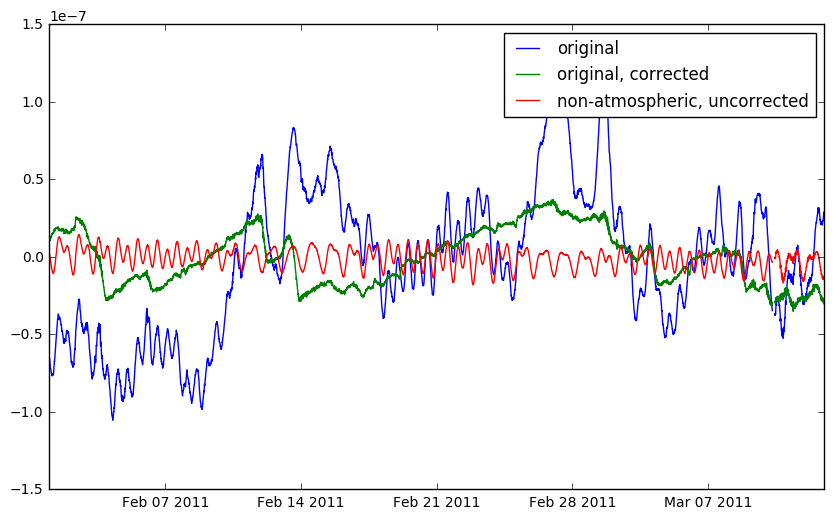

In [30]:
# compare these time series with the atmospheric components 
# both are uncorrected for tides and pressure
# the tides are still there, but 
# much of the variation disappears when we use the non-atmospheric components

tst=obspy.UTCDateTime(2011,2,1)
tnd=tst+40*86400.
from matplotlib.dates import date2num
tstp,tndp=date2num(tst),date2num(tnd)

# original components
tim,data=Strain.toplot.timdata(stc.select(channel='E-N')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii]-np.median(data[ii]),linestyle='-',marker=None,
                  label='original',color='b')

# original components, corrected
tim,data=Strain.toplot.timdata(stc2.select(channel='E-N')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii]-np.median(data[ii]),linestyle='-',marker=None,
                  label='original, corrected',color='g')

# non-atmospheric components
tim,data=Strain.toplot.timdata(sta.select(channel='E-N-na')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii]-np.median(data[ii]),linestyle='-',marker=None,
                  label='non-atmospheric, uncorrected',color='r')

lg = plt.legend()

In [31]:
# correct the non-atmospheric components for tides but not pressure

# a new set of fit parameters, to remove tides and atmospheric pressure
fpara = {'fittides':True,'fitatm':False}

# specify tidal coefficients that are expected to be visible at roughly one 
# standard deviation level
fpara['tidespec']='snr'
fpara['tidepar']=1.

# compute the correction parameters in a limited frequency band (specified in Hz)
# note the actual corrections are computed at all frequencies---it's only
# the parameters that are estimated after filtering
fpara['flm']=np.array([1./2.,6.])/86400.

# again, for the example, only use one year of data
fpara['starttime']=obspy.UTCDateTime(2011,1,1)
fpara['endtime']=obspy.UTCDateTime(2012,1,1)
print(fpara)


{'fitatm': False, 'flm': array([  5.78703704e-06,   6.94444444e-05]), 'starttime': UTCDateTime(2011, 1, 1, 0, 0), 'fittides': True, 'tidepar': 1.0, 'endtime': UTCDateTime(2012, 1, 1, 0, 0), 'tidespec': 'snr'}


In [32]:
# compute the correction parameters---will take a while
Xa,Xba=Strain.fits.fits.fit(sta,fpar=fpara)

In [33]:
# add these corrections
stac,stap=Strain.fits.fits.correct(sta,fpar=fpara,X=Xa)

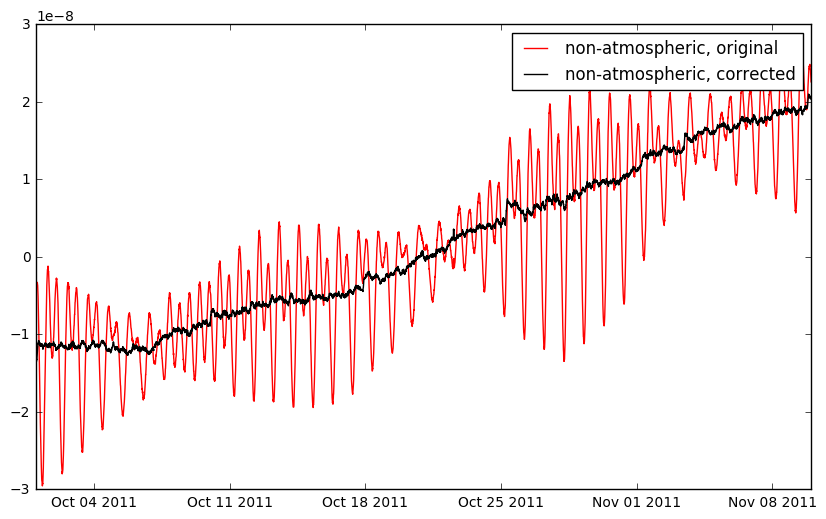

In [35]:
# examine the corrected data

tst=obspy.UTCDateTime(2011,10,1)
tnd=tst+40*86400.
from matplotlib.dates import date2num
tstp,tndp=date2num(tst),date2num(tnd)

# non-atmospheric components
tim,data=Strain.toplot.timdata(sta.select(channel='E-N-na')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii]-np.median(data[ii]),linestyle='-',marker=None,
                  label='non-atmospheric, original',color='r')

# non-atmospheric components, corrected
tim,data=Strain.toplot.timdata(stac.select(channel='E-N-na')[0])
ii=np.logical_and(tim>=tstp,tim<=tndp)
plt.plot_date(tim[ii],data[ii]-np.median(data[ii]),linestyle='-',marker=None,
              label='non-atmospheric, corrected',color='k')

lg = plt.legend()